In [13]:
#Importing Data
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_csv('musk_csv.csv')

In [14]:
print(df.shape)
print(df.head(5))

(6598, 170)


,ID,molecule_name,conformation_name,f1,f2,f3,f4,f5,f6,f7,...,f158,f159,f160,f161,f162,f163,f164,f165,f166,class
0,1,MUSK-211,211_1+1,46,-108,-60,-69,-117,49,38,...,-308,52,-7,39,126,156,-50,-112,96,1
1,2,MUSK-211,211_1+10,41,-188,-145,22,-117,-6,57,...,-59,-2,52,103,136,169,-61,-136,79,1
2,3,MUSK-211,211_1+11,46,-194,-145,28,-117,73,57,...,-134,-154,57,143,142,165,-67,-145,39,1
3,4,MUSK-211,211_1+12,41,-188,-145,22,-117,-7,57,...,-60,-4,52,104,136,168,-60,-135,80,1
4,5,MUSK-211,211_1+13,41,-188,-145,22,-117,-7,57,...,-60,-4,52,104,137,168,-60,-135,80,1


In [15]:
print(df.molecule_name.describe())
print(df.conformation_name.describe())

count              6598
unique              102
top       NON-MUSK-j146
freq               1044
Name: molecule_name, dtype: object
count         6598
unique        6598
top       j146_4+5
freq             1
Name: conformation_name, dtype: object


# Processing molecule_name
molecule_name has 102 unique values but the name also itself defines whether the chemical is MUSK or NON-MUSK i.e the classification task.  

In [16]:
#Cleaning molecule_name
from tqdm import tqdm
import re
processed_molecular_name = []
for sentance in tqdm(df['molecule_name'].values):
    sentance = re.sub(r"-", " ", sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub("[^a-zA-Z]+", "", sentance)
    sentance = ' '.join(e.lower() for e in sentance.split())
    processed_molecular_name.append(sentance.strip())

#adding processed molecule_name to dataframe
df['molecule_name_processed'] = processed_molecular_name

#Label Encoding molecule_name_processed to convert it into numerical form 
from sklearn.preprocessing import LabelEncoder
LE = LabelEncoder()
df['molecule_name_processed'] = LE.fit_transform(df['molecule_name_processed'])

100%|███████████████████████████████████| 6598/6598 [00:00<00:00, 76756.28it/s]


In [17]:
print(df.head(5))

,ID,molecule_name,conformation_name,f1,f2,f3,f4,f5,f6,f7,...,f159,f160,f161,f162,f163,f164,f165,f166,class,molecule_name_processed
0,1,MUSK-211,211_1+1,46,-108,-60,-69,-117,49,38,...,52,-7,39,126,156,-50,-112,96,1,0
1,2,MUSK-211,211_1+10,41,-188,-145,22,-117,-6,57,...,-2,52,103,136,169,-61,-136,79,1,0
2,3,MUSK-211,211_1+11,46,-194,-145,28,-117,73,57,...,-154,57,143,142,165,-67,-145,39,1,0
3,4,MUSK-211,211_1+12,41,-188,-145,22,-117,-7,57,...,-4,52,104,136,168,-60,-135,80,1,0
4,5,MUSK-211,211_1+13,41,-188,-145,22,-117,-7,57,...,-4,52,104,137,168,-60,-135,80,1,0


# Sliptting Data into train(0.8) and test(0.2)
## Note :- molecule_name_processed is dropped from the features as it would easily predict the classes.

In [18]:
#Seperating features and classes
x = df.drop(['conformation_name', 'class', 'molecule_name', 'ID','molecule_name_processed'], axis = 1)
y = df['class']

#Converting classes vector (integers) to binary class matrix to use it with categorical_crossentropy.
from keras.utils import to_categorical
y = to_categorical(y)

#Train Test Split
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, Y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)
print("Shape of Training Set = ", x_train.shape)

Shape of Training Set =  (5278, 166)


# Standardizing the features

In [19]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
x_train = ss.fit_transform(x_train)
x_test = ss.transform(x_test)

# MLP Model
1. MLP Model is chosen as its simple, robust and works well for classification tasks.
2. As the data available for training is very less so deeper NN might not work well.
3. Dense layers with 64,32,32 units are used along with relu activation function.
3. To prevent overfitting l2 regularization and Dropout are used.
4. Categorical_crossentropy is used over binary_crossentropy to easily convert probabilistic output to class labels using argmax.

In [21]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers.normalization import BatchNormalization
from keras.layers import Dropout
from keras import regularizers
import keras

reg = regularizers.l2(0.001)
input_dim = x_train.shape[1]
batch_size = 64
n_epoch = 25
output_dim = 2

model = Sequential()

model.add(Dense(64, activation= 'relu',input_shape=(input_dim,), activity_regularizer=reg))
model.add(Dropout(0.20))
model.add(Dense(32, activation= 'relu',activity_regularizer = reg))
model.add(Dense(32, activation= 'relu', activity_regularizer = reg))
model.add(Dense(output_dim, activation = "sigmoid"))
model.summary()
model.compile(optimizer = "adam", loss='categorical_crossentropy', metrics=['accuracy'])

result = model.fit(x_train,y_train, batch_size=batch_size, epochs=n_epoch, verbose=2, validation_data=(x_test, Y_test))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 64)                10688     
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_11 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_12 (Dense)             (None, 2)                 66        
Total params: 13,890
Trainable params: 13,890
Non-trainable params: 0
_________________________________________________________________
Train on 5278 samples, validate on 1320 samples
Epoch 1/25
 - 1s - loss: 1.8836 - acc: 0.7779 - val_loss: 0.9234 - val_acc: 0.8485
Epoch 2

# Plotting and printing Metrics

[]

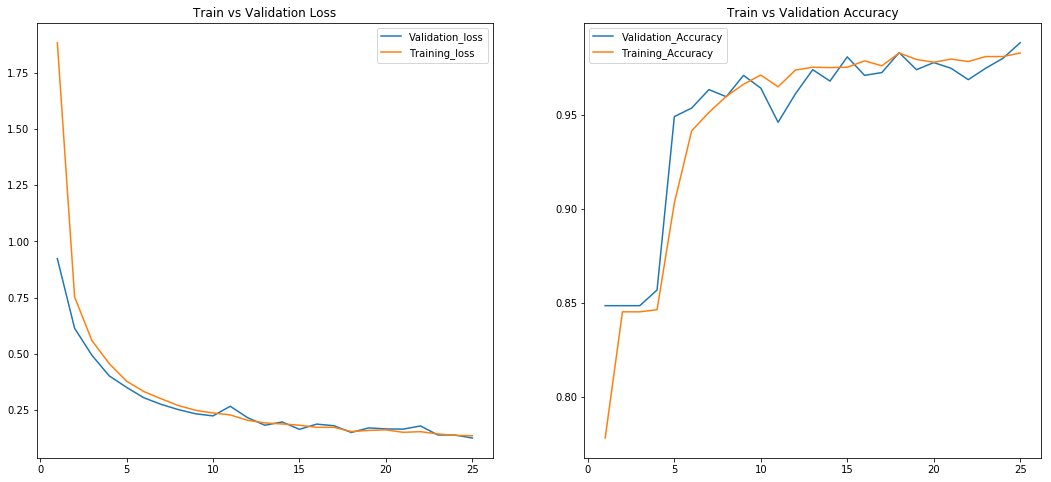

In [22]:
test_loss = result.history['val_loss']
train_loss = result.history['loss']
test_acc = result.history['val_acc']
train_acc = result.history['acc']

n_epoch_lst = list(range(1,n_epoch+1))

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(18,8))

#Plotting Train vs Validation loss
ax1 = plt.subplot(121)
ax1.plot(n_epoch_lst,test_loss, label='Validation_loss' )
ax1.plot(n_epoch_lst,train_loss, label='Training_loss')
plt.legend()
plt.title('Train vs Validation Loss')

#Plotting Train vs Validation Accuracy
ax2 = plt.subplot(122)
ax2.plot(n_epoch_lst,test_acc, label='Validation_Accuracy' )
ax2.plot(n_epoch_lst,train_acc, label='Training_Accuracy')
plt.legend()
plt.title('Train vs Validation Accuracy') 
plt.plot()

Validation Loss 0.09127355534018892
Validation Accuracy 98.86363636363636
********************
Train loss 0.13566809801745477
Train Accuracy 98.31375521030694
[[ 191    9]
 [   6 1114]]


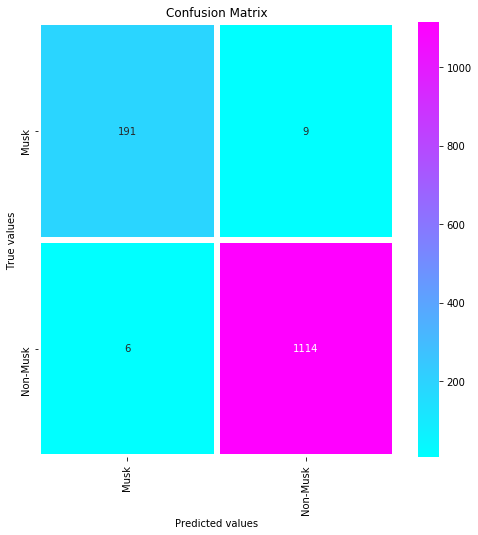

In [23]:
#Printing Training and Validation - Accuracy & Loss
score = model.evaluate(x_test, Y_test, verbose = 0)
print('Validation Loss',score[0])
print('Validation Accuracy',score[1]*100) 
print('*'*20)
print('Train loss',train_loss[-1])
print('Train Accuracy',train_acc[-1]*100)

#Predicting classes from validation set
Y_pred = model.predict(x_test)

#Converting Probabilistic prediction Output to Class labels (Musk or Non-Musk) 
Activities = {0:'Non-Musk',1:'Musk'}
y_pred = pd.Series([Activities[y] for y in np.argmax(Y_pred, axis=1)])
y_test = pd.Series([Activities[y] for y in np.argmax(Y_test, axis=1)])

#Confusion Matrix
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test, y_pred)
print(cm)
labels=['Musk','Non-Musk']
cm_df = pd.DataFrame(cm,index=labels, columns =labels) 

#Confusion Matrix Heatmap
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8,8))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='cool', linewidth=5)
plt.xlabel('Predicted values')
plt.ylabel('True values')
plt.xticks(rotation=90)
plt.title('Confusion Matrix')
plt.show()

In [24]:
#Using classification report to print other metrics (F1-score, Precision, Recall)
from sklearn import metrics
classificationreport = metrics.classification_report(y_test, y_pred)
print(classificationreport)

              precision    recall  f1-score   support

        Musk       0.97      0.95      0.96       200
    Non-Musk       0.99      0.99      0.99      1120

   micro avg       0.99      0.99      0.99      1320
   macro avg       0.98      0.97      0.98      1320
weighted avg       0.99      0.99      0.99      1320

